In [1]:
import numpy as np
from sympy.abc import a,x,y,z
from sympy import *
import matplotlib.pyplot as plt
#init_printing()
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

from "Mykel J. Kochenderfer, Tim A. Wheeler - Algorithms for Optimization (The MIT Press)-The MIT Press (2019)"

# Line search
We know the direction in which we want to search. It may be against the gradient or may be arbitrary.

We start our search at $\vec{x}_{i}$ and we search in the direction $\vec{d}_i$. 

$$\vec{x}_{i+1} = \vec{x}_i + \alpha_i \vec{d}_i$$
All points along this direction can be retrieved by line parametrization $\vec{l}(\alpha)$: 

$$\vec{l}(\alpha) = \vec{x}_i + \alpha \vec{d}_i$$
So $\vec{x}_{i+1}$ should be viewed as a function of $\alpha$ with
$$\vec{x}_{i+1} (\alpha = 0 ) = \vec{x}_i$$

Our task is to find $\alpha$ that minimizes our objective function
$$\alpha^*= \underset{\alpha}{\text{argmin }} f(\vec{l}(\alpha)) = \underset{\alpha}{\text{argmin }} f(\vec{x}  + \alpha \vec{d})$$

We know that a minima will occur at $\frac{d f}{d \alpha} = 0$

Manual example:
$$f(x_1,x_2,x_3) = sin(x_1 x_2) + exp(x_2 + x_3) - x_3$$
$$\vec{x}_0 + \alpha\vec{d} = \{1,2,3\} + \alpha\{0,-1,-1\}$$
$$f(\vec{x}_0 + \alpha\vec{d}) = sin((1 + 0)(2 - \alpha) ) + exp((2 - \alpha) + (3 - \alpha)) -  (3 - \alpha)$$
$$ = sin(2 - \alpha) + exp(5- 2\alpha)+ \alpha - 3$$
Solve
$$\frac{{d f(\vec{x}_0 + \alpha\vec{d})}}{d \alpha }= 0$$
Minimum at a ≈ 3.127...

> Lets test it with sympy

In [2]:
f = sin(x*y) + exp(y+z) - z
d,x0 = np.array([0,-1,-1]), np.array([1,2,3])
lx,ly,lz = x0 + a*d

>1. replace $\vec{x}$ with parametrized line
>2. take a derivative

In [3]:
f_of_a  = f.subs({x: lx, y: ly, z: lz})  # parametrize
dfda    = diff(f_of_a,a)    # calc derivative for arbitrary alpha
display(dfda)

-2*exp(5 - 2*a) - cos(a - 2) + 1

>Alternative:
>
>$$\frac{{\partial f}}{\partial \alpha} =  \nabla f(\vec{x}_i) \cdot \vec{d}_i$$
>1. Find gradient and evaluate at a line $\frac{{\partial f}}{\partial \vec{x} } \bigg|_{ \vec{x} = \vec{l}(\alpha)}$
>1. multiply by $\vec{d}$
>
> (see [gradient_jacobian_hessian.ipynb](../symbolic/gradient_jacobian_hessian.ipynb) for directional derivative info)

In [4]:
grad_f = Matrix([f]).jacobian((x,y,z))
print('grad = jac:', grad_f == Matrix([[diff(f, s) for s in (x,y,z)]]))
Dfa = grad_f.subs({x: lx, y: ly, z: lz})
dfda2 = Dfa.dot(d)
print('two approaches the same:', dfda == dfda2)

sol = float(nsolve(dfda, a, 1))
print(f'sol a= {sol:0.3f}; x = {x0 + sol*d}')

grad = jac: True
two approaches the same: True
sol a= 3.127; x = [ 1.         -1.12704561 -0.12704561]


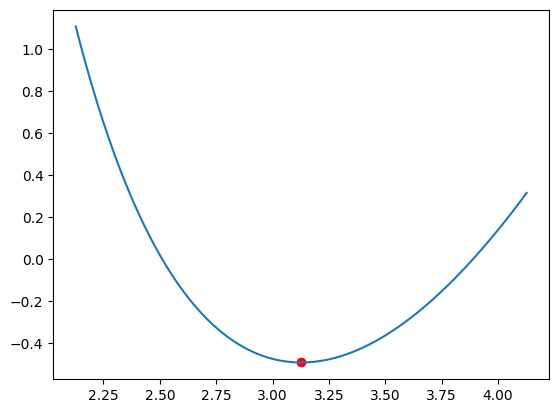

In [5]:
ff  = lambdify(a,f_of_a, 'numpy')
aas = np.linspace(sol - 1, sol + 1, 100)
plt.plot(aas, ff(aas))
plt.scatter([sol] ,[ff(sol)], c= 'r');

# Backtracking line search
When analytic expression for a gradient (over whole field) is unavailable we can only perform localized measurements and choose direction of descent.

But how does one selects a proper step length? Too large steps are unstable and small steps progress optimization slowly.

It is clear that we want to decrease function value

$$f(\vec{x}_{i+1} ) < f(\vec{x}_{i} + \alpha  \vec{d}_{i}) $$

In order to determine $\alpha$ we have to sample multiple versions and keep most suitable based on __Armijo__ and __Wolfe__ conditions.

_Source: https://youtu.be/Jxh2kqVz6lk_

We can formulate this condition in terms of $\alpha$ parameter

$$\tilde f(\alpha) = f(\vec{x}_{i} + \alpha  \vec{d}_{i})$$

We should restrict domain of $\alpha$ to one that satisfies

$$\tilde f(\alpha) < \underbrace{\tilde f(\alpha = 0)}_{\text{start}}$$



Text(0.5, 0, '$\\alpha$')

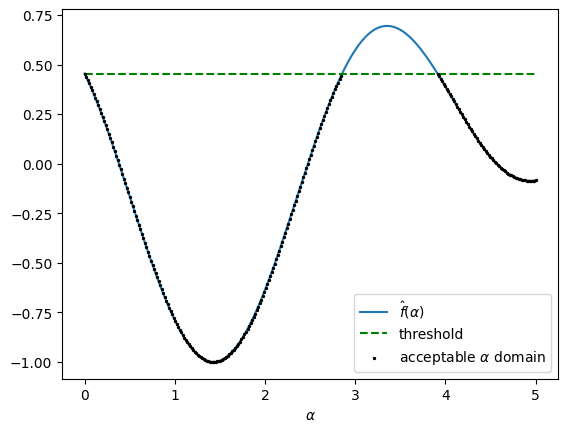

In [6]:

f2 = sin(x)*cos(y)
d,x0 = np.array([0.4,1.5]), np.array([1,1])
lx,ly = x0 + a*d

f_of_a = f2.subs({x: lx, y: ly})
f2_n = lambdify(a, f_of_a, 'numpy')
dfda = lambdify(a, diff(f_of_a,a), 'numpy')

nm = 300
xss = np.linspace(0, 5, nm)
sl = slice(0,nm//3)
#plt.plot(xss[sl], dfda(0)*xss[sl]+f2_n(0), ls = '--')
plt.plot(xss, f2_n(xss), label= r'$\hat{f}(\alpha)$')
filt = f2_n(xss) <= f2_n(0)
plt.plot(xss,   np.ones_like(xss)*f2_n(0), label='threshold', ls = '--', c = 'g')
plt.scatter(xss[filt], f2_n(xss[filt]), s = 2, label=r'acceptable $\alpha$ domain', c = 'k', zorder =2 )
plt.legend()
plt.xlabel(r'$\alpha$')

## Armijo condition (1st Wolfe condition)
Simple value check condition is too 'loose', domain of $\alpha$ is too big and this may result in overly large steps.

Instead we want to apply gradient information by using first order Taylor expansion 
$$\tilde f(\alpha) \leq \tilde f(0) + \beta_1 \alpha \underbrace{\nabla f(\vec{x}_{i}) \cdot \vec{d}_{i}}_{\text{Slope in step direction}}$$

We 'relax' slope by parameter $\beta_1$ so steps are not too small (1. maybe not entirely correct; 2. sometimes linear approximation will lie under the curve). 

As you see, as $\beta_1 \rightarrow 0$ we converge to original naive condition. 

In practice we start at $\tilde f(0) = f(\vec{x}_{i})$, have information about the gradient $\nabla f(\vec{x}_{i}) \cdot \vec{d}_{i}$, and compute different values $\tilde f(\alpha) = f(\vec{x}_{i+1})$
$$\boxed{f(\vec{x}_{i+1} ) \leq f(\vec{x}_{i} ) + \beta_1 \alpha \nabla f(\vec{x}_{i}) \cdot \vec{d}_{i}}$$


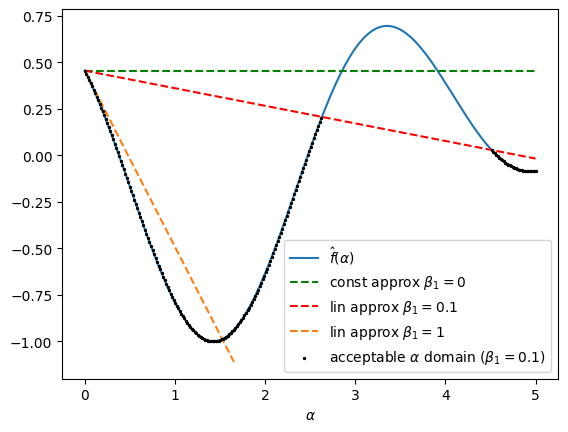

In [7]:
plt.plot(xss, f2_n(xss), label= r'$\hat{f}(\alpha)$')
plt.plot(xss,   np.ones_like(xss)*f2_n(0), label=r'const approx $\beta_1 = 0$', ls = '--', c = 'g')
beta_2 = 0.1
approx_2 = beta_2*dfda(0)*xss+f2_n(0)
plt.plot(xss, approx_2, ls = '--', label= r'lin approx $\beta_1 = 0.1$', c = 'r')
approx_1 = dfda(0)*xss[sl]+f2_n(0)
plt.plot(xss[sl], approx_1, ls = '--', label= r'lin approx $\beta_1 = 1$')
filt2 = f2_n(xss) <= approx_2
plt.scatter(xss[filt2], f2_n(xss[filt2]), s = 2, label=r'acceptable $\alpha$ domain ($\beta_1 = 0.1$)', c = 'k', zorder = 2)
plt.legend()
plt.xlabel(r'$\alpha$');

## 2nd Wolfe condition
Lets introduce shorter notation for directional derivative:
$$\nabla_{\vec{d}} f(\vec{x}_{i}) = \nabla f(\vec{x}_{i}) \cdot \vec{d}_{i}$$
We can add additional constraints for minimization. Our process of gradient descent takes us from high objective function value in direction of negative slope to a local minima with zero slope:
$$\nabla_{\vec{d}} f(\vec{x}_{i}) < \nabla_{\vec{d}} f(\vec{x}_{i+1})$$
Thus we want to exclude from search $\alpha$'s which have steeper gradients. We can also introduce additional hyperparameter $\beta_2$, so solution is least $\beta_2$ times less steep than at initial start point.
$$\boxed{\nabla_{\vec{d}} f(\vec{x}_{i+1}) \geq \beta_2 \nabla_{\vec{d}} f(\vec{x}_{i})} $$
or to account 'both' directions around minimum _(using abs $|\cdot|$ our negative slopes turn positive)_:
$$\boxed{|\nabla_{\vec{d}} f(\vec{x}_{i+1})| \leq |\beta_2 \nabla_{\vec{d}} f(\vec{x}_{i})|} $$
use of (2nd) Wolfe condition allows to neglect small $\alpha$'s, since slope change is small.


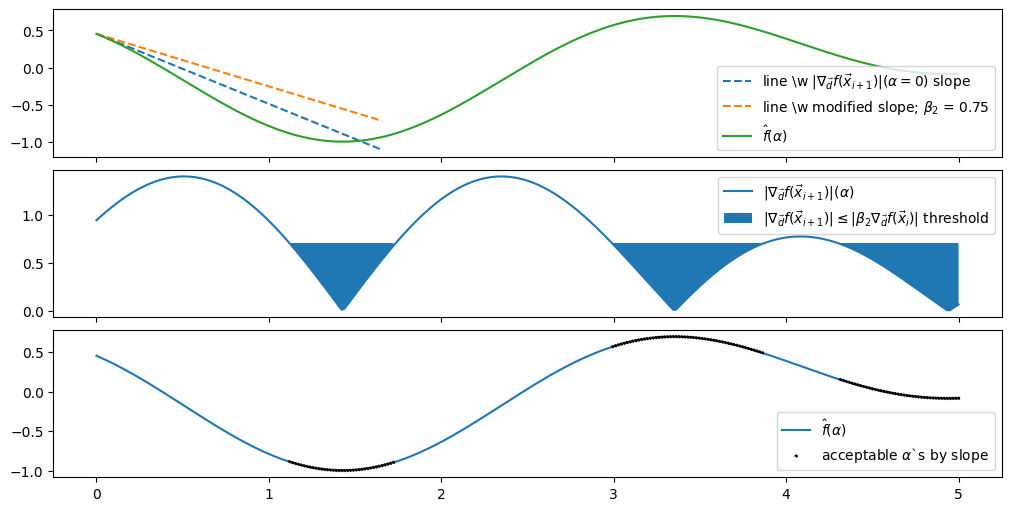

In [8]:
fig, ax = plt.subplots(3,1, figsize = (2*5,5), layout='constrained', sharex=1)
ax[2].plot(xss, f2_n(xss), label= r'$\hat{f}(\alpha)$')
approx_1 = dfda(0)*xss[sl]+f2_n(0)
ax[0].plot(xss[sl], approx_1, ls = '--', label= r'line \w $|\nabla_{\vec{d}} f(\vec{x}_{i+1})|(\alpha = 0)$ slope')
beta_2 = 0.75
approx_3 = beta_2*dfda(0)*xss[sl]+f2_n(0)
ax[0].plot(xss[sl], approx_3, ls = '--', label= r'line \w modified slope; $\beta_2$ = ' + str(beta_2) )
filt3 = np.abs(dfda(xss)) <= beta_2*np.abs(dfda(0))

ax[1].plot(xss, np.abs(dfda(xss)), label= r'$|\nabla_{\vec{d}} f(\vec{x}_{i+1})|(\alpha)$')
#plt.hlines(beta_2*np.abs(dfda(0)), xss.min(), xss.max(), label= r'derivative threshold')
ax[1].fill_between(xss, np.abs(dfda(xss)), beta_2*np.abs(dfda(0)), where= filt3, label = r'$|\nabla_{\vec{d}} f(\vec{x}_{i+1})| \leq |\beta_2 \nabla_{\vec{d}} f(\vec{x}_{i})|$ threshold' )
ax[0].plot(xss, f2_n(xss), label= r'$\hat{f}(\alpha)$')
ax[2].scatter(xss[filt3], f2_n(xss[filt3]), ls = '--', label= r'acceptable $\alpha$`s by slope', s = 2, c = 'k', zorder =2 )
ax[0].legend();ax[1].legend();ax[2].legend()

Procedure of backtracking line search is the following
1. calculate function value and gradient at start
1. select large step size
1. check conditions for step size. if they fail reduce step size by factor $\rho$
1. repeat or end

cleaner example in the module [line_search_method.py](line_search_method.py)

Example:

$$f(x_1, x_2) = x_1^2 + x_1 x_2 + x_2^2$$ 
$$\vec{x} = \{1,2\}$$
$$\vec{d} = \{-1,-1\}$$
$$\nabla f (\vec{r}) = \{2 x_1 + x_2, 2 x_2 + x_1\}$$

In [9]:
f = pow(x,2) +x*y + pow(y,2) 
d,x0 = np.array([-1,-1]), np.array([1,2])
alpha = 10
rho = 0.5
beta = 1e-4
grad_f = Matrix([f]).jacobian((x,y))

sub_d = lambda vec: {x:vec[0], y:vec[1]}
grad_f_pt = grad_f.subs(sub_d(x0))
gd = grad_f_pt.dot(d)
sol = float('inf')
f_x = f.subs(sub_d(x0))
i = 0
while True:
    xad = x0 + alpha*d
    f_xad = f.subs(sub_d(xad))
    print(f'{i = };\t {alpha = };\t {f_xad = :0.1f};\t {f_x + beta*alpha*gd = :0.3f};\t {xad = }')
    if f_xad <=  f_x + beta*alpha*gd:
        sol = xad
        break

    alpha *= rho
    i += 1

# second Wolfe condition check
sigma = 0.9
print_tex(f'${grad_f.subs(sub_d(sol)).dot(d):0.3f} \geq {sigma*grad_f.subs(sub_d(x0)).dot(d):0.3f}$')

i = 0;	 alpha = 10;	 f_xad = 217.0;	 f_x + beta*alpha*gd = 6.991;	 xad = array([-9, -8])
i = 1;	 alpha = 5.0;	 f_xad = 37.0;	 f_x + beta*alpha*gd = 6.996;	 xad = array([-4., -3.])
i = 2;	 alpha = 2.5;	 f_xad = 3.2;	 f_x + beta*alpha*gd = 6.998;	 xad = array([-1.5, -0.5])


<IPython.core.display.Math object>